# Helpfulness Classification

#### Table of Contents
1. [Data Preparation](#1.-Data-Preparation)
   1. [Load Dataset](#1.1-Loading-the-Helpful-Sentences-from-Reviews-Dataset)
   2. [Pre-processing](#1.2-Pre-processing-the-data)
2. [Model Training](#2.-Model-Training)
   1. [Set up](#2.1-Set-up)
   2. [Fine-tuning BERT Model](#22-fine-tuning-bert-model)
   3. [Ensemble Learning](#2.3-Ensemble-Learning-Bagging-Algorithm)
3. [Experiments](#3.-Experiments)
   1. [Set up](#3.1-Set-up)
   2. [The overall performance of the model](#32-the-overall-performance-of-the-model)
   3. [Experiments - Convert the task to classification problem](#33-experiments---convert-the-task-to-classification-problem)

In [38]:
######### Please specify the path of model checkpoints #########
# standard_model_ckpt = "./model/standard_model"
# ensemble_checkpoint_path = "./model/ensemble/"
standard_model_ckpt = "/local/home/p11333at/nlu/standard_model"
ensemble_checkpoint_path = "/local/home/p11333at/nlu/ensemble/"
################################################################

DatasetDict({
    train: Dataset({
        features: ['sentence', 'helpful', 'product_title', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['sentence', 'helpful', 'product_title', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
})

In [39]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error, classification_report
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import load_dataset, Dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Apr 25 18:01:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V

## 1. Data Preparation

### 1.1 Loading the "Helpful Sentences from Reviews" Dataset

In [3]:
# Path of dataset
data_files = {"train": "./data/train.json", "test": "./data/test.json"}

# Load dataset
dataset = load_dataset("json", data_files=data_files["test"], split='train')\
          .remove_columns(["asin", "main_image_url"])


# Split into train and test data -> 80% : 20%
split_dataset = dataset.train_test_split(train_size=0.8, seed=42) # Shuffled by default
split_dataset

Found cached dataset json (/local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
Loading cached split indices for dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-507c488b89086b5a.arrow and /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-8f3a243ad04e0776.arrow


DatasetDict({
    train: Dataset({
        features: ['sentence', 'helpful', 'product_title'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['sentence', 'helpful', 'product_title'],
        num_rows: 400
    })
})

### 1.2 Pre-processing the data

#### 1.2.1 Setup

In [4]:
model_ckpt = "distilbert-base-uncased"

kwargs = {
    "num_labels": 1,
    "activation": "sigmoid",
}

bert_model = AutoModelForSequenceClassification.from_pretrained(standard_model_ckpt, **kwargs)
bert_model = bert_model.to(device)  # Send the model to GPU if available

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, **kwargs)

#### 1.2.2 Define the pre-processing functions

In [5]:
def normalize_labels(row):
    """ The value of "helpfulness" is in range of 0 <= helpful <= 2,
        After this process, the value of "labels" is in range of 0 <= labels <= 1
    """
    row["labels"] = row["helpful"]/2
    return row

def tokenization(row):
    return tokenizer(
        row["sentence"], 
        truncation=True, 
        padding="max_length", 
        max_length=70   # The 'max_length' is chosen after experiments (which can be found in section 2.1)
    )

#### 1.2.3 Pre-process the data

In [6]:
tokenized_dataset = split_dataset.map(normalize_labels).map(tokenization, batched=True)

tokenized_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

tokenized_dataset

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-ac5d6c0892fe1882.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-7592f7767856374a.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-e147419d6db59c78.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-cfafcdd27b27207f.arrow


DatasetDict({
    train: Dataset({
        features: ['sentence', 'helpful', 'product_title', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['sentence', 'helpful', 'product_title', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
})

#### 1.2.4 Experiment: Find the most appropriate max_length for padding of tokenizer

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-01d64343cb38d9ea.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-a215bf8b0913c848/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-25e3951bcf5b94d8.arrow


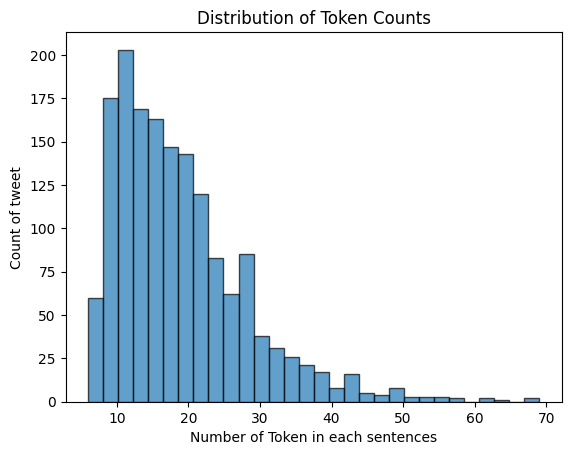

The max number of tokens in the dataset: 69


In [7]:
# Calculate the length of tokens in tokenized reviews
# (to help determine the max_length for padding)
trial_dataset = split_dataset.map(
    lambda row: tokenizer(row["sentence"]), 
    batched=True
)

input_token_length = np.array(
    [len(input_ids) for input_ids in trial_dataset['train']["input_ids"]], 
    # dtype=torch.float
)

plt.hist(input_token_length, bins=30, edgecolor='k', alpha=0.7)
plt.gca().set(
    title='Distribution of Token Counts', 
    xlabel='Number of Token in each sentences',
    ylabel='Count of tweet'
)

plt.show()

print(f"The max number of tokens in the dataset: {np.max(input_token_length)}")

## 2. Model Training

### 2.1 Set up

#### 2.1.1 Define Metrics

In [8]:
# Method for Computing Accuracy
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

#### 2.1.2 Set up the training arguments

In [9]:
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=15,
    learning_rate=3e-5,  # Default: 5e-05
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy= "steps",    # 'epoch', 'steps'
    eval_steps=100,
    logging_steps=100,
    logging_strategy= "steps",
    # gradient_accumulation_steps=8,
    metric_for_best_model="eval_mse",
    load_best_model_at_end=True,
)

early_stop = EarlyStoppingCallback(
    early_stopping_patience=3, 
    early_stopping_threshold=0.001
)

### 2.2 Fine-tuning BERT Model

#### 2.2.1 Load the trained BERT model

In [10]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    compute_metrics=compute_metrics_for_regression,
)

#### 2.2.2 Evaluate the model

In [26]:
res = trainer.predict(tokenized_dataset["test"])
single_model_predictions = res.predictions.squeeze()
single_model_metrics = res.metrics
print(f''' ------ Metrics Evaluation ------
Mean Squared Error:         {single_model_metrics['test_mse']:.3f}
Root Mean Squared Error:    {single_model_metrics['test_rmse']:.3f}
Mean Absolute Error:        {single_model_metrics['test_mae']:.3f}
R2 Score:                   {single_model_metrics['test_r2']:.3f}
''')

 ------ Metrics Evaluation ------
Mean Squared Error:         0.015
Root Mean Squared Error:    0.123
Mean Absolute Error:        0.096
R2 Score:                   0.605



### 2.3  Ensemble Learning (Bagging Algorithm)


#### 2.3.1 Set up

In [12]:
file_list = sorted([f"{ensemble_checkpoint_path}{filename}" for filename in os.listdir(ensemble_checkpoint_path) if filename != 'standard_model'])
file_list

['/local/home/p11333at/nlu/ensemble/member_01',
 '/local/home/p11333at/nlu/ensemble/member_02',
 '/local/home/p11333at/nlu/ensemble/member_03',
 '/local/home/p11333at/nlu/ensemble/member_04',
 '/local/home/p11333at/nlu/ensemble/member_05',
 '/local/home/p11333at/nlu/ensemble/member_06',
 '/local/home/p11333at/nlu/ensemble/member_07',
 '/local/home/p11333at/nlu/ensemble/member_08',
 '/local/home/p11333at/nlu/ensemble/member_09',
 '/local/home/p11333at/nlu/ensemble/member_10',
 '/local/home/p11333at/nlu/ensemble/member_11',
 '/local/home/p11333at/nlu/ensemble/member_12',
 '/local/home/p11333at/nlu/ensemble/member_13',
 '/local/home/p11333at/nlu/ensemble/member_14',
 '/local/home/p11333at/nlu/ensemble/member_15',
 '/local/home/p11333at/nlu/ensemble/member_16',
 '/local/home/p11333at/nlu/ensemble/member_17',
 '/local/home/p11333at/nlu/ensemble/member_18',
 '/local/home/p11333at/nlu/ensemble/member_19',
 '/local/home/p11333at/nlu/ensemble/member_20']

#### 2.3.2 Load the ensemble models & Make predictions

In [13]:
evaluation_list = []

for checkpoint in file_list:
    # Load the trained model
    bert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, **kwargs)
    bert_model = bert_model.to(device)  # Send the model to GPU if available

    trainer_ensemble = Trainer(
        model=bert_model,
        args=training_args,
        compute_metrics=compute_metrics_for_regression,
    )
    
    # Emsemble prediction
    eval_result = trainer_ensemble.predict(tokenized_dataset["test"])
    evaluation_list.append(eval_result)

# Ensemble prediction
prediction_list = np.array([eval.predictions for eval in evaluation_list])
metrics_list = np.array([eval.metrics for eval in evaluation_list])

loading configuration file /local/home/p11333at/nlu/ensemble/member_01/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_01",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file /local/home/p11333at/nlu/ensemble/member_01/pytorch_model.bin
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_01",
  "act

loading configuration file /local/home/p11333at/nlu/ensemble/member_02/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_02",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_02",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_03/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_03",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_03",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_04/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_04",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_04",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_05/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_05",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_05",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_06/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_06",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_06",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_07/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_07",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_07",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_08/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_08",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_08",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_09/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_09",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_09",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_10/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_10",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_10",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_11/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_11",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_11",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_12/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_12",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_12",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_13/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_13",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_13",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_14/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_14",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_14",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_15/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_15",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_15",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_16/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_16",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_16",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_17/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_17",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_17",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_18/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_18",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_18",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_19/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_19",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_19",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

loading configuration file /local/home/p11333at/nlu/ensemble/member_20/config.json
Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_20",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

Model config DistilBertConfig {
  "_name_or_path": "/local/home/p11333at/nlu/ensemble/member_20",
  "activation": "sigmoid",
  "architectures": [
    "DistilBertForSequenceClassification"

#### 2.3.3 Combine the predictions of different models as an ensemble prediction

In [14]:
true = tokenized_dataset["test"]["labels"].cpu().numpy()

# Calculate the prediction of ensembles with different size
ensemble_prediction_list = []
for i in range(len(file_list)):
    ensemble_predictions = np.mean(prediction_list[:i+1], axis=0).squeeze()
    ensemble_prediction_list.append(ensemble_predictions)
ensemble_prediction_list = np.array(ensemble_prediction_list)

# Collect the metrics for each ensemble member
ensemble_metric_dict = {"mse": [], "rmse": [], "mae": [], "r2": []}
for pred in ensemble_prediction_list:
    single_metric = compute_metrics_for_regression((pred, true))
    for key in ensemble_metric_dict:
        ensemble_metric_dict[key].append(single_metric[key])

#### 2.3.4 Evaluate the ensemble model

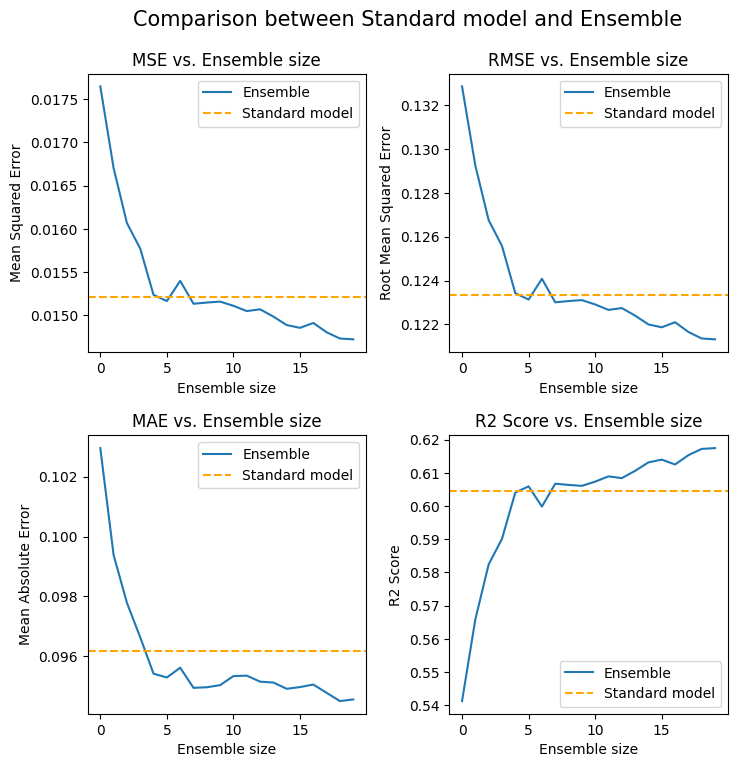

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(np.arange(len(file_list)), ensemble_metric_dict["mse"], label='Ensemble')
axs[0, 0].axhline(y=single_model_metrics["test_mse"], color='orange', linestyle='--', label='Standard model')
axs[0, 0].set_xlabel('Ensemble size')
axs[0, 0].set_ylabel('Mean Squared Error')
axs[0, 0].set_title('MSE vs. Ensemble size')
axs[0, 0].legend()


axs[0, 1].plot(np.arange(len(file_list)), ensemble_metric_dict["rmse"], label='Ensemble')
axs[0, 1].axhline(y=single_model_metrics["test_rmse"], color='orange', linestyle='--', label='Standard model')
axs[0, 1].set_xlabel('Ensemble size')
axs[0, 1].set_ylabel('Root Mean Squared Error')
axs[0, 1].set_title('RMSE vs. Ensemble size')
axs[0, 1].legend()


axs[1, 0].plot(np.arange(len(file_list)), ensemble_metric_dict["mae"], label='Ensemble')
axs[1, 0].axhline(y=single_model_metrics["test_mae"], color='orange', linestyle='--', label='Standard model')
axs[1, 0].set_xlabel('Ensemble size')
axs[1, 0].set_ylabel('Mean Absolute Error')
axs[1, 0].set_title('MAE vs. Ensemble size')
axs[1, 0].legend()


axs[1, 1].plot(np.arange(len(file_list)), ensemble_metric_dict["r2"], label='Ensemble')
axs[1, 1].axhline(y=single_model_metrics["test_r2"], color='orange', linestyle='--', label='Standard model')
axs[1, 1].set_xlabel('Ensemble size')
axs[1, 1].set_ylabel('R2 Score')
axs[1, 1].set_title('R2 Score vs. Ensemble size')
axs[1, 1].legend()


plt.suptitle('Comparison between Standard model and Ensemble', fontsize=15)
# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# Show the figure
plt.show()

## 3. Experiments

### 3.1  Set up



In [16]:
true = tokenized_dataset['test']['labels'].cpu().numpy()    # Extract true labels (Detach from GPU as well)

######### Uncomment ONLY one of the following lines #########
pred_s = single_model_predictions  # For standard model
pred_e = ensemble_prediction_list[-1]   # For ensemble model
#############################################################

### 3.2 The overall performance of the model

#### 3.2.1 Evaluation graph - for standard model

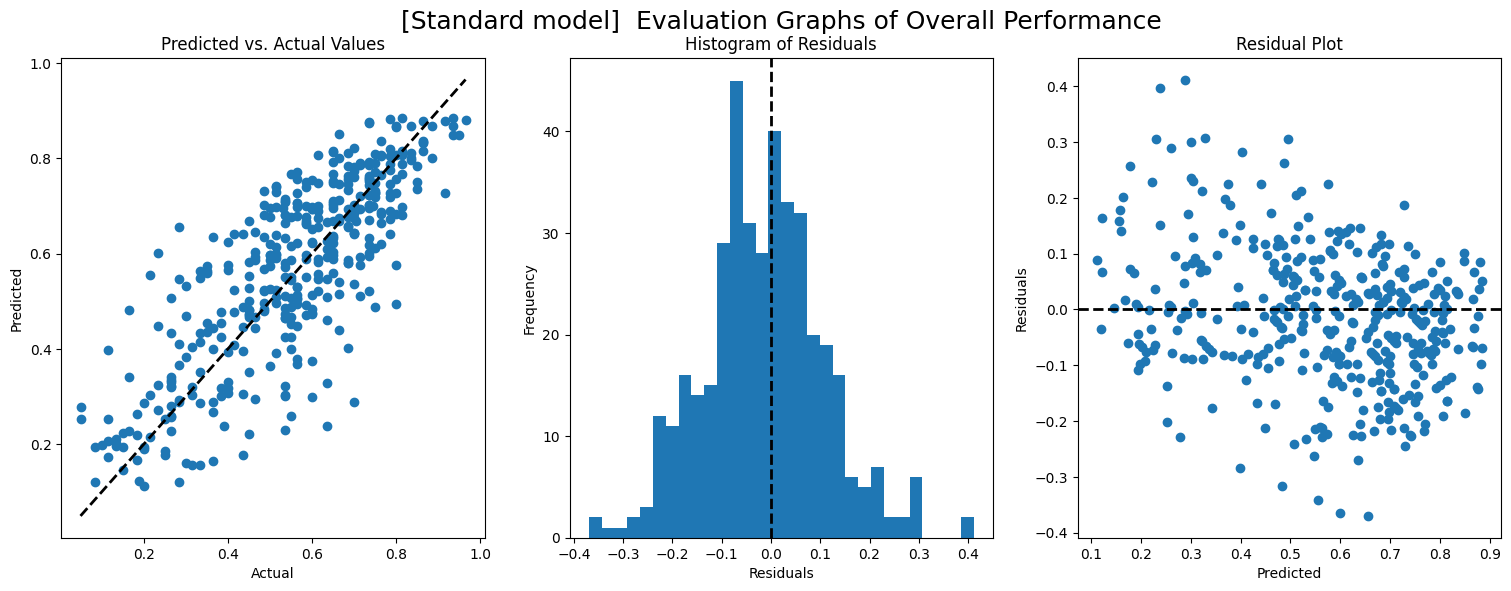

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(true, pred_s)
axs[0].plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Predicted vs. Actual Values')


residuals = true - pred_s
axs[1].hist(residuals, bins=30)
axs[1].axvline(x=0, color='k', linestyle='--', lw=2)
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Residuals')


axs[2].scatter(pred_s, residuals)
axs[2].axhline(y=0, color='k', linestyle='--', lw=2)
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Residual Plot')

fig.suptitle('[Standard model]  Evaluation Graphs of Overall Performance', fontsize=18)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

#### 3.2.2 Evaluation graph - for ensemble model

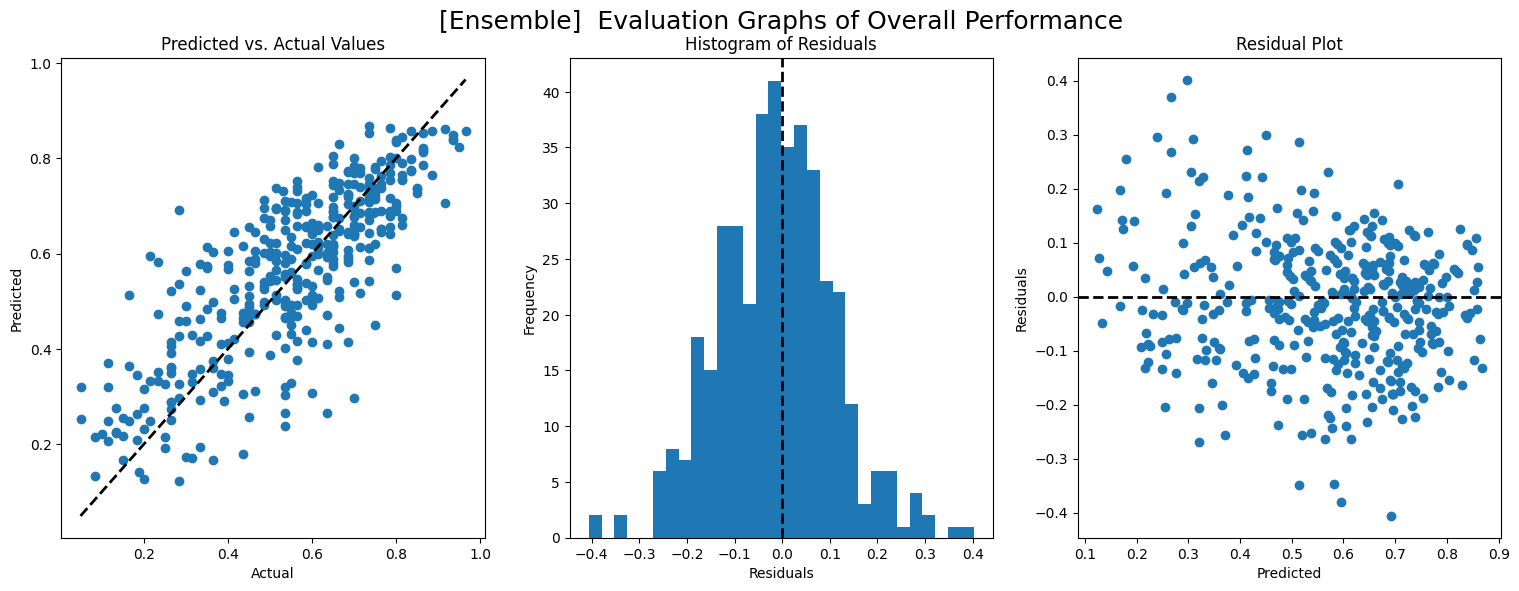

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(true, pred_e)
axs[0].plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Predicted vs. Actual Values')


residuals = true - pred_e
axs[1].hist(residuals, bins=30)
axs[1].axvline(x=0, color='k', linestyle='--', lw=2)
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Residuals')


axs[2].scatter(pred_e, residuals)
axs[2].axhline(y=0, color='k', linestyle='--', lw=2)
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Residual Plot')

fig.suptitle('[Ensemble]  Evaluation Graphs of Overall Performance', fontsize=18)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

### 3.3 Experiments - Convert the task to classification problem

#### 3.3.1 Two classes classification
    Classify a review as:
        1. Helpful
        2. Not Helpful


In [19]:
# 0-1 | 1-2
def convert_value_to_2_labels(true, pred):
    true = true*2
    pred = pred*2
    bins = [0, 1, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred_s = convert_value_to_2_labels(true, pred_s)

lable_true, label_pred_e = convert_value_to_2_labels(true, pred_e)

print("\n======= Classification Report for ( 2 ) Labels =======")
print("------------------- Standard Model -------------------")
print(classification_report(lable_true, label_pred_s, target_names=["Not Helpful", "Helpful"]))

print("\n---------------------- Ensemble ----------------------")
print(classification_report(lable_true, label_pred_e, target_names=["Not Helpful", "Helpful"]))
print("======================================================")
print("           The improvement is not obvious")
print("======================================================")


======= Classification Report for ( 2 ) Labels =======
------------------- Standard Model -------------------
              precision    recall  f1-score   support

 Not Helpful       0.73      0.74      0.73       132
     Helpful       0.87      0.86      0.87       268

    accuracy                           0.82       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.82      0.82      0.82       400


---------------------- Ensemble ----------------------
              precision    recall  f1-score   support

 Not Helpful       0.74      0.72      0.73       132
     Helpful       0.86      0.87      0.87       268

    accuracy                           0.82       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.82      0.82      0.82       400

           The improvement is not obvious


#### 3.3.2 Three classes classification
    Classify a review as:
        1. "Not Helpful"
        2. "Slightly Helpful"
        3. "Very Helpful"

In [20]:
# 0-0.66 | 0.66-1.33 | 1.33-2
def convert_value_to_3_labels(true, pred):
    true = true*2
    pred = pred*2
    bins = [0, 0.66, 1.33, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred_s = convert_value_to_3_labels(true, pred_s)

lable_true, label_pred_e = convert_value_to_3_labels(true, pred_e)

print("\n======= Classification Report for ( 3 ) Labels =======")
print("------------------- Standard Model -------------------")
print(classification_report(lable_true, label_pred_s, target_names=["Not Helpful", "Slightly Helpful", "Very Helpful"]))

print("\n---------------------- Ensemble ----------------------")
print(classification_report(lable_true, label_pred_e, target_names=["Not Helpful", "Slightly Helpful", "Very Helpful"]))
print("======================================================")
print("Overall accuracy is improved by 2% using ensemble model")
print("======================================================")


======= Classification Report for ( 3 ) Labels =======
------------------- Standard Model -------------------
                  precision    recall  f1-score   support

     Not Helpful       0.65      0.69      0.67        62
Slightly Helpful       0.74      0.64      0.69       206
    Very Helpful       0.66      0.78      0.72       132

        accuracy                           0.69       400
       macro avg       0.68      0.70      0.69       400
    weighted avg       0.70      0.69      0.69       400


---------------------- Ensemble ----------------------
                  precision    recall  f1-score   support

     Not Helpful       0.66      0.56      0.61        62
Slightly Helpful       0.71      0.74      0.72       206
    Very Helpful       0.71      0.72      0.72       132

        accuracy                           0.70       400
       macro avg       0.69      0.67      0.68       400
    weighted avg       0.70      0.70      0.70       400

Overall accurac

#### 3.3.3 Four classes classification 
    Classify a review as:
        1. "Not Helpful"
        2. "Slightly Helpful"
        3. "Helpful"
        4. "Very Helpful"

In [21]:
# 0-0.5 | 0.5-1.0 | 1.0-1.5 | 1.5-2
def convert_value_to_4_labels(true, pred):
    true = true*2
    pred = pred*2
    bins = [0, 0.5, 1, 1.5, 2]
    true_classes = np.digitize(true, bins)
    pred_classes = np.digitize(pred, bins)
    return true_classes, pred_classes

lable_true, label_pred_s = convert_value_to_4_labels(true, pred_s)

lable_true, label_pred_e = convert_value_to_4_labels(true, pred_e)

print("\n======= Classification Report for ( 4 ) Labels =======")
print("------------------- Standard Model -------------------")
print(classification_report(lable_true, label_pred_s, target_names=["Not Helpful", "Slightly Helpful", "Helpful", "Very Helpful"]))

print("\n---------------------- Ensemble ----------------------")
print(classification_report(lable_true, label_pred_e, target_names=["Not Helpful", "Slightly Helpful", "Helpful", "Very Helpful"]))
print("======================================================")
print("Overall accuracy is improved by 4% using ensemble model")
print("======================================================")


======= Classification Report for ( 4 ) Labels =======
------------------- Standard Model -------------------
                  precision    recall  f1-score   support

     Not Helpful       0.59      0.58      0.58        33
Slightly Helpful       0.54      0.57      0.55        99
         Helpful       0.70      0.67      0.68       203
    Very Helpful       0.55      0.62      0.58        65

        accuracy                           0.62       400
       macro avg       0.60      0.61      0.60       400
    weighted avg       0.63      0.62      0.63       400


---------------------- Ensemble ----------------------
                  precision    recall  f1-score   support

     Not Helpful       0.62      0.45      0.53        33
Slightly Helpful       0.54      0.58      0.56        99
         Helpful       0.70      0.76      0.73       203
    Very Helpful       0.68      0.52      0.59        65

        accuracy                           0.65       400
       macro avg

### 3.4 Test with your own input

In [74]:
reviews = [
    # Very Helpful
    {"sentence": "The battery life of this smartphone is impressive; it lasted me the entire day with heavy usage."},
    {"sentence": "I love the camera quality on this DSLR - the images are sharp, and the colors are vibrant."},
    {"sentence": "This vacuum cleaner has excellent suction power, making it easy to clean pet hair and dirt from carpets."},
    # Slightly Helpful
    {"sentence": "The phone's OS is even better than iphone. Good!"},
    {"sentence": "The tablet works fine for browsing, but I haven't tried other things."},
    {"sentence": "My daughter dislikes the book because the story is boring."},
    # Not Helpful
    {"sentence": "I don't like this product."},
    {"sentence": "I like this mouse pad, but my son doesn't."},
    {"sentence": "It's okay, I guess."},
    {"sentence": "I will try it when I got time."},
]

reviews = Dataset.from_list(reviews)
tokenised_reviews = reviews.map(tokenization)
res = trainer.predict(tokenised_reviews)

# Convert to three class
bins = [0, 0.33, 0.66, 1]
classes = np.digitize(res.predictions.squeeze(), bins)

# Print the results
for i, c in enumerate(classes):
    string = ""
    if c == 3:
        string += "[Very Helpful]\t\t"
    elif c == 2:
        string += "[Slightly Helpful]\t"
    elif c == 1:
        string += "[Not Helpful]\t\t"
    string += reviews[i]["sentence"]
    print(string)